In [40]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import polygon
from scipy.ndimage import filters,convolve, binary_dilation
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.exposure import equalize_hist
from skimage.segmentation import ( morphological_chan_vese,
                                    checkerboard_level_set)
import math
import copy
import cv2
from skimage.feature import canny


def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 


In [41]:
def morphChaneVese(image, itr=80, p=3):
    """
        calculate the segmentation mask of the image using morphological_chan_vese built in function.
        Args:
            img: RGB image to calculate the segmentation mask over it.
            itr: number of iterations used to get the segmentation mask, default = 120.
            p: square width of the initial segmentation mask, default = 3.
        Returns:
            Binary image represents the filled object.
    """
    image = copy.deepcopy(image)
    #turn RGB image to gray scaled one.
    image = rgb2gray(image)
    #apply histogram equalization to enhance the image.
    image = equalize_hist(image)
    #set the initial segmentation mask base on p value.
    init_ls = checkerboard_level_set(image.shape, p)
    #calculate the mask using morphological_chan_vese algorithm.
    mask = morphological_chan_vese(image, num_iter=itr, init_level_set=init_ls, smoothing=2)
    # Invert the mask to get the object.
    mask = np.invert(mask)
    
    #return the calculated mask
    return mask

In [42]:
# #for edge detection
# def gradient(image):
#     """
#         Calculate sobel gradient magnitude for grayscaled image,
#         Args:
#             image: gray-scaled image.

#         Returns:
#             gray-scaled image of the magnitude of the gradient.
#     """
#     # vertical and horizontal filters decleration for gradient calculations.
#     hx = np.array([[1, 2, 1], [0, 0, 0],  [-1, -2, -1]] ) /4.0
#     hy = hx.T
#     #convolve the image with the filters to detect vertical and horizontal lines
#     Ix = convolve(image, hx)
#     Iy = convolve(image, hy)
#     #return the magnitude of each pixel gradient
#     return np.sqrt(Ix**2+Iy**2)


# def SobelRGB(image):

#     """
#         Calculate sobel gradient magnitude for each channel in RGB image,
#         Args:
#             image: RGB image.

#         Returns:
#             gray-scaled image of the magnitude of the gradient.
#     """
#     #change the image scale from 0:255 to 0:1 scale
#     r = image[:,:,0].astype('float32')
#     g = image[:,:,1].astype('float32')
#     b = image[:,:,2].astype('float32')
#     X,Y = r.shape
#     r /= 255
#     g /= 255
#     b /= 255
#     #calculate the gradient for each channel
#     r = gradient(r)
#     b = gradient(b)
#     g = gradient(g)
#     Gm = np.zeros([X,Y])
#     #total image gradient is the maximum value of the three channels
#     for i in range (0,X):
#         Gm[i] = np.maximum( np.maximum(r[i] , g[i]), b[i])
#     #return the final result
#     return Gm

# #segmentation mask by blurring
# def segBlurring(image , sigma =20):
#     """
#         Segment RGB image using RGB-edge detection thenblurring the edges with high sigma (20),
#         Args:
#             image: RGB image.
#             sigma: the sigma of the gaussian filter applied to the edged image, default = 20.

#         Returns:
#             gray-scaled image represent the segmentation mask.
#     """
#     image = copy.deepcopy(image)
#     conv = SobelRGB(image)
#     return gaussian (conv , sigma)

In [43]:
def watershed_segmentation(img):
    # Convert BGR to RGB
    b, g, r = cv2.split(img)
    rgb_img = cv2.merge([r, g, b])

    # Convert image to grayscale
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    
    # Apply histogram equalization to enhance the image.
    gray = cv2.equalizeHist(gray)

    # Ensure the image is of type CV_8U (8-bit unsigned integer)
    gray = np.uint8(gray)

    # Apply Otsu's thresholding for optimal threshold value
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Noise removal with morphological closing
    filter = np.ones((2, 2), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, filter, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(closing, filter, iterations=3)
    
    return sure_bg


In [44]:
def watershed_segmentation_markers(img, markers):

    # Ensure the image is of type CV_8U (8-bit unsigned integer)
    gray = np.uint8(img)

    # Apply Otsu's thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal with morphological closing
    kernel = np.ones((2, 2), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(closing, kernel, iterations=3)

    # Combine markers with sure background
    sure_bg[markers > 0] = 0

    # Find contours in the sure background
    contours, _ = cv2.findContours(sure_bg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for each contour
    mask = np.zeros_like(gray)
    for i, contour in enumerate(contours):
        cv2.drawContours(mask, [contour], 0, i + 1, -1)

    # Label each region in the mask
    labeled_regions, num_labels = cv2.connectedComponents(mask)

    # Return the labeled regions
    return labeled_regions

In [45]:
def otsu_segmentation_binary_mask(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Otsu's thresholding
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal
    kernel = np.ones((2, 2), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(closing, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 3)

    # Threshold
    ret, sure_fg = cv2.threshold(dist_transform, 0.1 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labeling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    # Watershed segmentation
    markers = cv2.watershed(img, markers)

    # Create a binary mask based on watershed result
    binary_mask = np.zeros_like(gray) 
    binary_mask[markers == 1] = 255  # Assuming the sure background is labeled as 1

    # Invert the binary mask
    inverted_mask = cv2.bitwise_not(binary_mask)

    return inverted_mask

In [46]:
# sobel segmentation
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.feature import canny
from scipy import ndimage

def canny_segmentation_optimized(img,sigma=3,dilation_size=5):
    # Convert image to grayscale
    img_gray = rgb2gray(img)
    
    #apply histogram equalization to enhance the image.
    img_gray = equalize_hist(img_gray)

    # Apply Canny detector
    edges = canny(img_gray, sigma=sigma)
    
    # Dilate the edges
    edges = morphology.dilation(edges, morphology.disk(dilation_size))
    
    # Fill holes
    filled = ndimage.binary_fill_holes(edges)

    return filled
        

In [47]:
def kmeans_segmentation(img, k=2):
    # Convert image to 1D array of float32
    pixels = img.reshape((-1, 3)).astype(np.float32)

    # Define criteria and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to 8-bit values
    centers = np.uint8(centers)

    # Map the labels to the centers
    segmented_image = centers[labels.flatten()]

    # Reshape the segmented image back to the original shape
    segmented_image = segmented_image.reshape(img.shape)
    
    # Binary Threshold inverted
    segmented_image= cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
    ret, segmented_image = cv2.threshold(segmented_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    

    return segmented_image


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.filters import sobel
from skimage import morphology
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.color import label2rgb

def region_based_segmentation(img):
    # Convert image to grayscale
    img = rgb2gray(img)
    
    # Compute elevation map using the Sobel filter
    elevation_map = sobel(img)

    # Create markers based on intensity thresholds
    markers = np.zeros_like(img)
    markers[img < 0.4] = 1
    markers[img > 0.5] = 2

    # Apply watershed segmentation
    segmentation = watershed(elevation_map, markers)

    # Fill holes and label the regions
    segmentation = ndi.binary_fill_holes(segmentation - 1)
    labeled_img, _ = ndi.label(segmentation)
    
    # make it binary inverted
    labeled_img = np.where(labeled_img > 0, 0, 1)

    return labeled_img


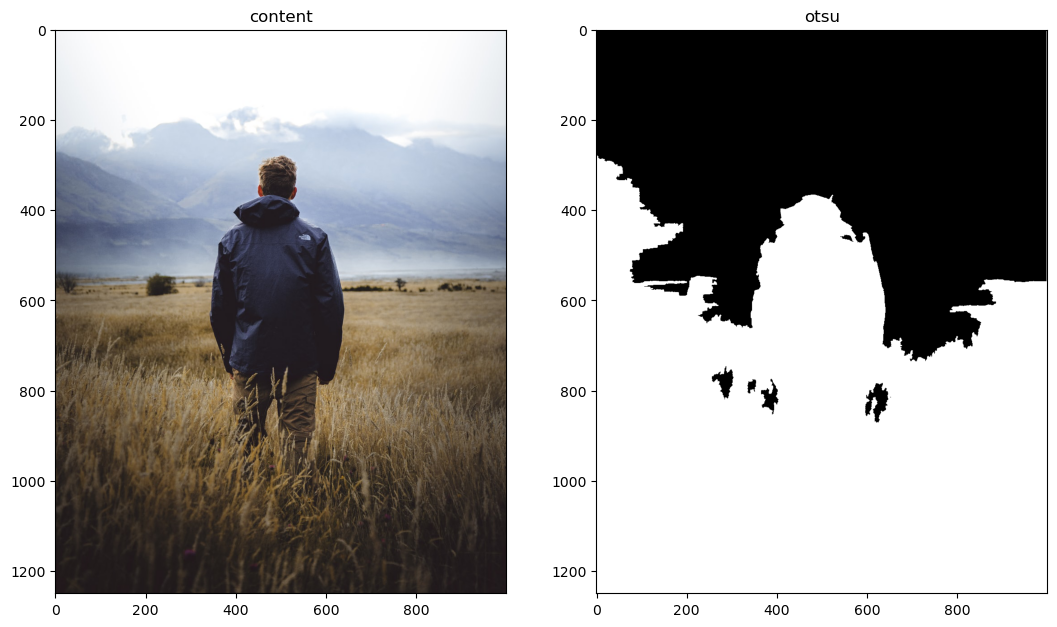

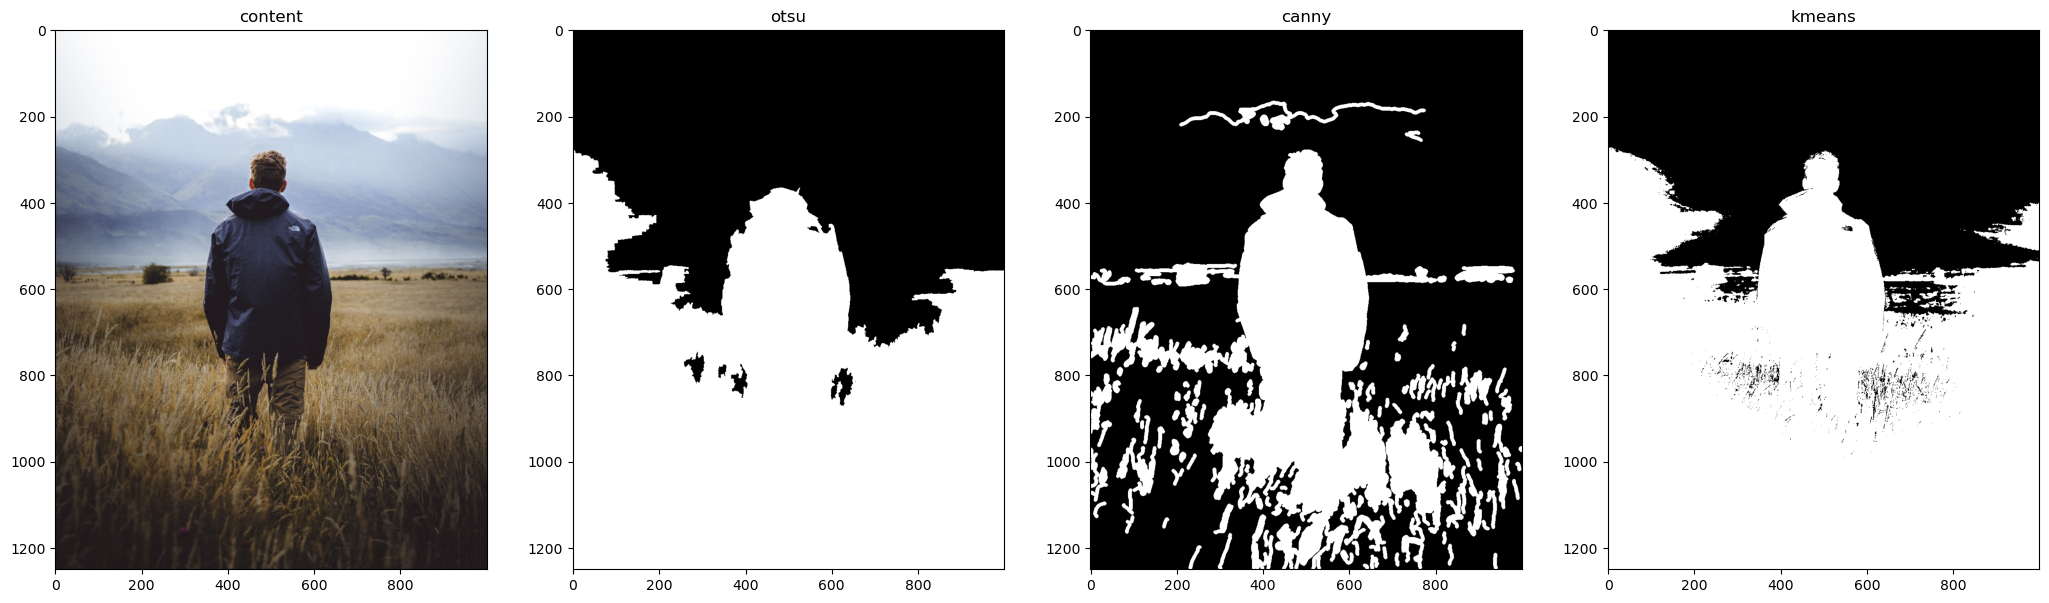

In [53]:
content_image = io.imread('../../input/content/mo.jpeg')
# content_water = watershed_segmentation(content_image)
# show_images([content_image, content_water], ['content', 'water'])

# content_morph = morphChaneVese(content_image, 10, 3)
content_otsu = otsu_segmentation_binary_mask(content_image) 
content_canny = canny_segmentation_optimized(content_image , 2 , 4)
content_kmeans = kmeans_segmentation(content_image)
# content_region = region_based_segmentation(content_image)

show_images([content_image, content_otsu], ['content', 'otsu'])

show_images([content_image,content_otsu, content_canny, content_kmeans], ['content', 'otsu', 'canny', 'kmeans'])

